## XGBoost

In [1]:
import pandas as pd
owid_covid = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
owid_covid["date"] = pd.to_datetime(owid_covid["date"])
df = owid_covid[owid_covid.location == "France"].set_index("date", drop=True).resample('D').interpolate(method='linear').reset_index()


In [10]:
from sklearn.base import TransformerMixin, BaseEstimator
class DateFeatures(TransformerMixin, BaseEstimator):
    features = [
        "hour",
        "year",
        "day",
        "weekday",
        "month",
        "quarter",
    ]
    
    def __init__(self):
        super().__init__()
    def transform(self, df: pd.DataFrame):
        Xt = []
        for col in df.columns:
            for feature in self.features:
                date_feature = getattr(
                    getattr(
                        df[col], "dt"
                    ), feature
                )
                date_feature.name = f"{col}_{feature}"
                Xt.append(date_feature)
        
        df2 = pd.concat(Xt, axis=1)
        return df2
    def fit(self, df: pd.DataFrame, y=None, **fit_params):
        return self


In [11]:
from sklearn.compose import ColumnTransformer
from feature_engine.creation import CyclicalFeatures

from sklearn.pipeline import Pipeline, make_pipeline
preprocessor = ColumnTransformer(
    transformers=[(
        "date",
        make_pipeline(
            DateFeatures(),
            ColumnTransformer(transformers=[
                ("cyclical", CyclicalFeatures(),
                  ["date_day", "date_weekday", "date_month"]
                )
            ], remainder="passthrough")
        ), ["date"],
  ),], remainder="passthrough"
)


In [12]:
from xgboost import XGBRegressor
pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
         ("xgb", XGBRegressor(objective="reg:squarederror", n_estimators=1000))
    ]
)


In [ ]:
TRAIN_SIZE = int(len(df) * 0.9)
HORIZON = 1
TARGET_COL = "new_cases"


In [14]:
X_train, X_test = df.iloc[HORIZON:TRAIN_SIZE], df.iloc[TRAIN_SIZE+HORIZON:]
y_train = df.shift(periods=HORIZON).iloc[HORIZON:TRAIN_SIZE][TARGET_COL]
y_test = df.shift(periods=HORIZON).iloc[TRAIN_SIZE+HORIZON:][TARGET_COL]


In [15]:
FEATURE_COLS = ["date"]
pipeline.fit(X_train[FEATURE_COLS], y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date',
                                                  Pipeline(steps=[('datefeatures',
                                                                   DateFeatures()),
                                                                  ('columntransformer',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('cyclical',
                                                                                                    CyclicalFeatures(),
                                                                                                    ['date_day',
                                                                                                     'date_weekday',
                                                                                                     'date_month'])]))]),
                                                  ['date'])])),
                ('xgb',
                 XGBRegressor(base_score=None, b...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=1000,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [16]:
MAX_HORIZON = 90
X_test_horizon = pd.Series(pd.date_range(
    start=df.date.min(), 
    periods=len(df) + MAX_HORIZON,
    name="date"
)).reset_index()


In [17]:
forecasted = pd.concat(
    [pd.Series(pipeline.predict(X_test_horizon[FEATURE_COLS])), pd.Series(X_test_horizon.date)],
    axis=1
)
forecasted.columns = [TARGET_COL, "date"]


In [18]:
actual = pd.concat(
    [pd.Series(df[TARGET_COL]), pd.Series(df.date)],
    axis=1
)
actual.columns = [TARGET_COL, "date"]


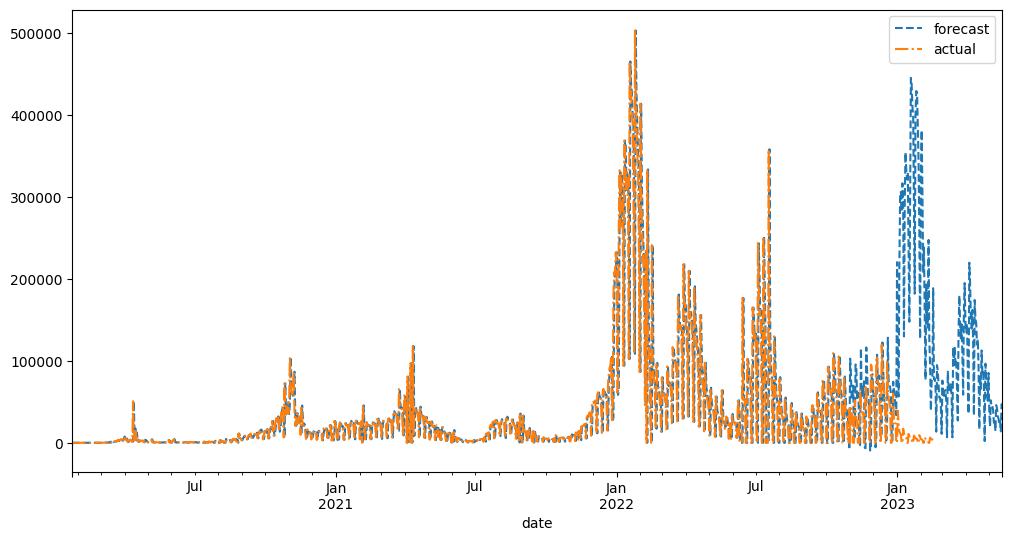

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
forecasted.set_index("date").plot(linestyle='--', ax=ax)
actual.set_index("date").plot(linestyle='-.', ax=ax)
plt.legend(["forecast", "actual"])


In [21]:
from sklearn.metrics import mean_squared_error
test_data = actual.merge(forecasted, on="date", suffixes=("_actual", "_predicted"))
mse = mean_squared_error(test_data.new_cases_actual, test_data.new_cases_predicted, squared=False)  # RMSE
print("The root mean squared error (RMSE) on test set: {:.2f}".format(mse))


The root mean squared error (RMSE) on test set: 71524.00


## SkTime

In [24]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
forecaster.fit(y_train) 
y_pred = forecaster.predict(MAX_HORIZON)

## XGBoost with Darts

In [9]:
import pandas as pd
from darts.timeseries import TimeSeries
#from darts.models.forecasting.lgbm import LightGBMModel
from darts.models.forecasting.xgboost import XGBModel
from darts.datasets import AirPassengersDataset

series = AirPassengersDataset().load()
# alternatively, something like this:
# df = pd.read_csv('AirPassengers.csv', delimiter=",")
# series = TimeSeries.from_dataframe(df, 'Month', ['#Passengers'])
train, val = series.split_before(pd.Timestamp('19540101'))
model = XGBModel(lags=15)
model.fit(train)
forecast = model.predict(HORIZON)


In [12]:
from darts.dataprocessing.transformers.scaler import Scaler
add_encoders={
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['hour', 'dayofweek']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'transformer': Scaler()
}


## CatBoost

In [13]:
from sktime.forecasting.compose import make_reduction
import lightgbm as lgb
regressor = lgb.LGBMRegressor()
forecaster = make_reduction(
    regressor,
    window_length=10,
    strategy="recursive",
    scitype="tabular-regressor"
)


## Ensembles

### with Kats

The kats installation is a bit particular and finicky. You might need to install a separate environment to make this work.

In [ ]:
!MINIMAL_KATS=1 pip install kats --no-deps  # the kats installation is a bit particular

In [ ]:
pip install 'packaging==21.3'

In [ ]:
pip install prophet

In [2]:
df = owid_covid[owid_covid.location == "France"].set_index("date", drop=True).resample('D').interpolate(method='linear').reset_index()

In [3]:
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import linear_model, quadratic_model
model_params = EnsembleParams(
            [
                BaseModelParams("linear", linear_model.LinearModelParams()),
                BaseModelParams("quadratic", quadratic_model.QuadraticModelParams()),
            ]
        )


In [4]:
KatsEnsembleParam = {
    "models": model_params,
    "aggregation": "weightedavg",
    "seasonality_length": 30,
    "decomposition_method": "additive",
}


In [5]:
from kats.consts import TimeSeriesData
TARGET_COL = "new_cases"
df_ts = TimeSeriesData(
    value=df[TARGET_COL], time=df["date"]
)


In [6]:
m = KatsEnsemble(
    data=df_ts, 
    params=KatsEnsembleParam
).fit()


/opt/anaconda3/envs/book/lib/python3.10/site-packages/kats/utils/backtesters.py:210: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((truth - predictions) / truth))
/opt/anaconda3/envs/book/lib/python3.10/site-packages/kats/utils/backtesters.py:210: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((truth - predictions) / truth))
/opt/anaconda3/envs/book/lib/python3.10/site-packages/kats/models/ensemble/kats_ensemble.py:832: RuntimeWarning: invalid value encountered in double_scalars
  model: err / sum(original_weights.values())


Text(0, 0.5, 'new_cases')

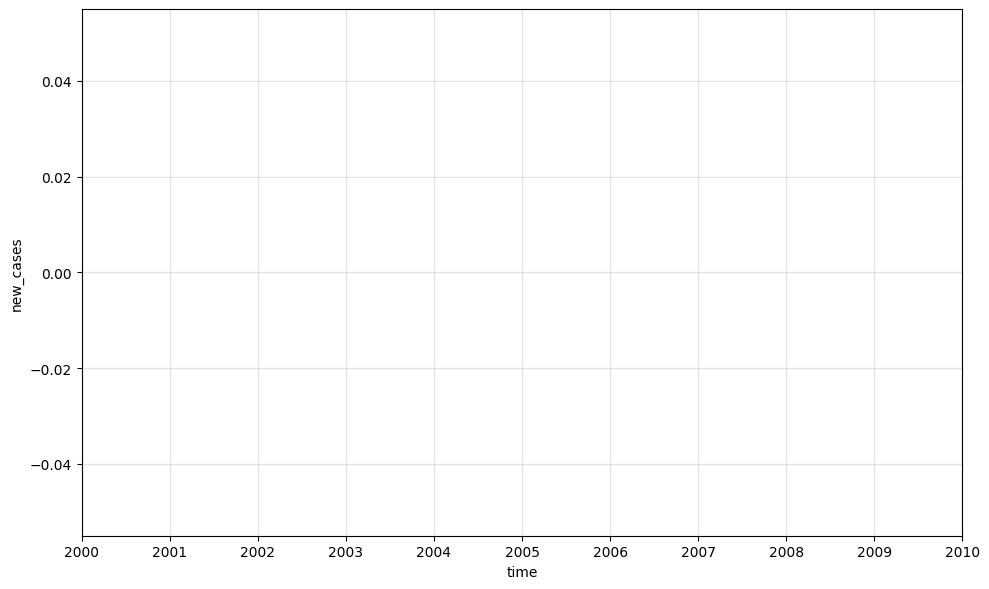

In [7]:
import matplotlib.pyplot as plt

m.predict(steps=90)
m.aggregate()
m.plot()
plt.ylabel(TARGET_COL)


### with darts

  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 4.85


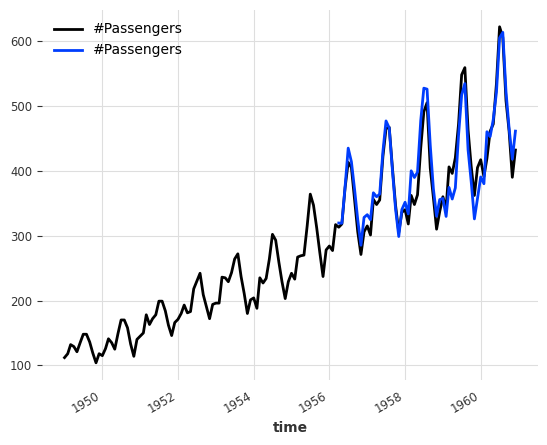

In [12]:
import numpy as np
from darts.models import NaiveDrift, NaiveSeasonal
from darts.models import RegressionEnsembleModel
from darts.datasets import AirPassengersDataset
from darts.metrics import mape

series_air = AirPassengersDataset().load().astype(np.float32)

models = [NaiveDrift(), NaiveSeasonal(12)]

ensemble_model = RegressionEnsembleModel(
    forecasting_models=models, regression_train_n_points=12
)

backtest = ensemble_model.historical_forecasts(
    series_air, start=0.6, forecast_horizon=3, verbose=True
)

print("MAPE = %.2f" % (mape(backtest, series_air)))
series_air.plot()
backtest.plot()
